In [1]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Corrected import statement
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report
from tensorflow.keras import layers, callbacks
from tqdm import  tqdm
import random

2025-11-03 22:59:34.542459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762185574.654463    1053 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762185574.687143    1053 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762185574.926757    1053 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762185574.926804    1053 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762185574.926808    1053 computation_placer.cc:177] computation placer alr

An error occurred: module 'importlib.metadata' has no attribute 'packages_distributions'


/home/pomp/miniconda3/envs/tf/lib/python3.9/site-packages/google/api_core/_python_version_support.py:252: FutureWarning: You are using a Python version (3.9.23) past its end of life. Google will update google.api_core with critical bug fixes on a best-effort basis, but not with any other fixes or features. Please upgrade to the latest Python version, or at least Python 3.10, and then update google.api_core.
  warnings.warn(message, FutureWarning)


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.keras.backend.clear_session()

In [4]:
IMG_SIZE = 256
IMG_DIM = 3

In [5]:
BATCH_SIZE = 32

In [6]:
BASE_DATA_PATH = './splited2'
# BASE_DATA_PATH = './edc_extended_compressed_splited'
# BASE_DATA_PATH = './witheddfsAI/edcsplited'

In [ ]:
# load dataset
# train_dir = '/home/pomp/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1/dataset'
train_dir = f'{BASE_DATA_PATH}/train'
val_dir = f'{BASE_DATA_PATH}/val'

# Load training dataset without preprocessing
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    seed=random.randint(0, 127127),
    shuffle=True,
)

# Load validation dataset without preprocessing
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    seed=random.randint(0, 127127),
)

Found 3372 files belonging to 4 classes.


I0000 00:00:1762185579.281427    1053 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 419 files belonging to 4 classes.


In [8]:
random.randint(0, 127127)

11307

In [9]:
# Get the class names from the subdirectories in the training directory
class_names = sorted(os.listdir(train_dir))

# Print the class names and the number of classes
print("Class Names:", class_names)
num_classes = len(class_names)
print("Number of Classes:", num_classes)

Class Names: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Number of Classes: 4


In [10]:
# for faster training which takes less time and less memory for training
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
# Augmentation for training dataset
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.5),
    layers.RandomFlip()
])

In [12]:
# Using MobileNetV2 model of transfer learning for training 
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

/tmp/ipykernel_1053/3300457734.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))


In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# greyscale = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x*tf.constant([0.21, 0.72, 0.07]), axis=-1, keepdims=True), output_shape=(IMG_SIZE, IMG_SIZE, 1))
# greyscale_to_rgb_dim = tf.keras.layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1), output_shape=(IMG_SIZE, IMG_SIZE, 3))

# rescaling the data
# rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1) 
# rescale = tf.keras.layers.Rescaling(1./255)

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255)
])

base_model.trainable = False

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)

In [15]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, IMG_DIM))
# x = data_augmentation(inputs)
x = resize_and_rescale(inputs)

# x = greyscale(x)
# x = greyscale_to_rgb_dim(x)


# x = preprocess_input(x)
# x = rescale(x)
# x = resize_and_rescale(x)

x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [17]:
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.best_epcoh = 0
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_weights= self.model.get_weights()

In [18]:
# Define EarlyStopping callback
# early_stopping = callbacks.EarlyStopping(patience=100, restore_best_weights=True, verbose=1)
save_best_model = SaveBestModel()

with tf.device("/gpu:0"):
    # Train the model with early stopping
    history = model.fit(
        train_ds,
        epochs=100,
        validation_data=val_ds,
        # callbacks=[early_stopping], # Add the EarlyStopping callback to the training process
        callbacks=[save_best_model]
    )

Epoch 1/100


I0000 00:00:1762185594.559215    1334 service.cc:152] XLA service 0x73c254003300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762185594.561672    1334 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-11-03 22:59:54.786316: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762185595.736554    1334 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/106 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.2100 - loss: 1.7017 

I0000 00:00:1762185604.930154    1334 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5798 - loss: 0.9768

2025-11-03 23:00:15.052967: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1292', 636 bytes spill stores, 636 bytes spill loads

2025-11-03 23:00:15.159133: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1292', 884 bytes spill stores, 884 bytes spill loads

2025-11-03 23:00:18.175739: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1292', 8 bytes spill stores, 8 bytes spill loads

2025-11-03 23:00:18.542867: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1292', 432 bytes spill stores, 432 bytes spill loads



106/106 ━━━━━━━━━━━━━━━━━━━━ 40s 166ms/step - accuracy: 0.5809 - loss: 0.9745 - val_accuracy: 0.8091 - val_loss: 0.5104
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7954 - loss: 0.5267 - val_accuracy: 0.8473 - val_loss: 0.4430
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8316 - loss: 0.4549 - val_accuracy: 0.8735 - val_loss: 0.4021
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8483 - loss: 0.4092 - val_accuracy: 0.8687 - val_loss: 0.3874
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8620 - loss: 0.3811 - val_accuracy: 0.8807 - val_loss: 0.3861
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8731 - loss: 0.3661 - val_accuracy: 0.8878 - val_loss: 0.3658
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8823 - loss: 0.3316 - val_accuracy: 0.8902 - val_loss: 0.3653
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8833 - loss: 0.3476 - val_accura

2025-11-03 23:04:33.755420: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 41943296 bytes after encountering the first element of size 41943296 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9442 - loss: 0.1600 - val_accuracy: 0.8854 - val_loss: 0.3756
Epoch 84/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9452 - loss: 0.1541 - val_accuracy: 0.8926 - val_loss: 0.3732
Epoch 85/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9369 - loss: 0.1610 - val_accuracy: 0.8831 - val_loss: 0.3815
Epoch 86/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9402 - loss: 0.1639 - val_accuracy: 0.8998 - val_loss: 0.3648
Epoch 87/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9427 - loss: 0.1632 - val_accuracy: 0.8759 - val_loss: 0.3741
Epoch 88/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9404 - loss: 0.1651 - val_accuracy: 0.8926 - val_loss: 0.3752
Epoch 89/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9394 - loss: 0.1579 - val_accuracy: 0.8902 - val_loss: 0.3711
Epoch 90/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9411 - loss: 0.1624 - val_a

In [19]:
save_best_model.best

0.32886791229248047

In [20]:
model.set_weights(save_best_model.best_weights)

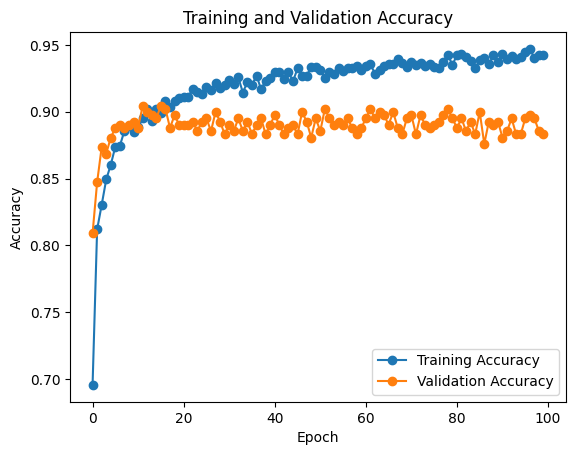

In [21]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

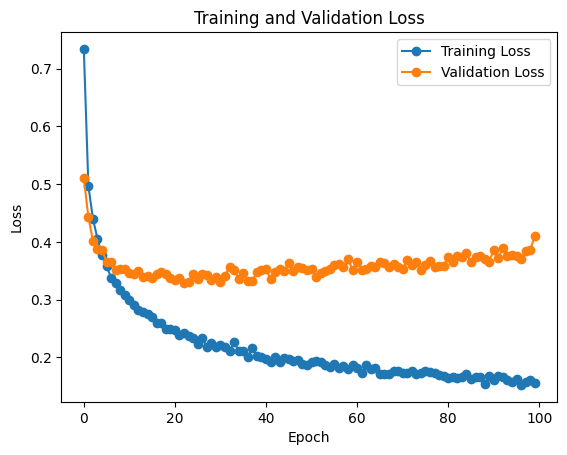

In [22]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss',marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss',marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [23]:
test_dir = './splited/test'
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size=1,
    image_size=(256, 256),
    seed=random.randint(0, 127127),
)

Found 511 files belonging to 4 classes.


In [24]:
# from sklearn.metrics import confusion_matrix, classification_report

In [25]:
# cor = 0
# pred = 0

# for i, batch in enumerate(tqdm(test_ds)):
#     image, label = batch[0][0], batch[1][0]

#     img_array = tf.keras.utils.img_to_array(image.numpy())
#     img_array = tf.expand_dims(img_array, 0)

#     predictions = model.predict(img_array, verbose=0)
    
#     choice = np.argmax(predictions[0])

#     predicted_class = class_names[choice]
#     confidence = round(100*(choice), 0)
    
    
#     actual_class = class_names[label]
    
#     cor += 1
#     if choice == label:
#         pred += 1

#     if i % 20 == 0:
#         print(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
    
# print(f"Accuracy: {pred/cor}")

In [26]:
# pred, cor

In [27]:
loss, acc = model.evaluate(test_ds, batch_size=32)

511/511 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8999 - loss: 0.2842


In [28]:
loss, acc

(0.24381552636623383, 0.908023476600647)

In [29]:
model.save('eyeclss003.keras')

In [30]:
# model.export('eyeclss0002')

In [31]:
# keras.config.enable_unsafe_deserialization()
# loaded_model = tf.keras.models.load_model('./eyeclss002.keras')
# loaded_model.summary()

In [32]:
# test_dir = './splited/test'
# test_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     test_dir,
#     batch_size=1,
#     image_size=(IMG_SIZE, IMG_SIZE),
#     seed=42,
# )

In [33]:
# cor = 0
# pred = 0

# class_names = sorted(os.listdir(train_dir))

# for i, batch in enumerate(tqdm(test_ds)):
#     image, label = batch[0][0], batch[1][0]

#     img_array = tf.keras.utils.img_to_array(image.numpy())
#     img_array = tf.expand_dims(img_array, 0)

#     predictions = loaded_model(img_array, verbose=0)
    
#     choice = np.argmax(predictions[0])

#     predicted_class = class_names[choice]
#     confidence = round(100*(choice), 0)
    
    
#     actual_class = class_names[label]
    
#     cor += 1
#     if choice == label:
#         pred += 1

#     if i % 20 == 0:
#         print(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
    
# print(f"Accuracy: {pred/cor}")

In [34]:
# keras.config.enable_unsafe_deserialization()
# loaded_model = tf.keras.models.load_model('./eyeclss001.keras')
# loaded_model.summary()

In [35]:
# loaded_model.export("saved_model")

In [36]:
# import tf2onnx
# import onnx

In [37]:
# onnx_model, _ = tf2onnx.convert.from_keras(loaded_model)
# python -m tf2onnx.convert --saved-model path/to/savedmodel --output dst/path/model.onnx